In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
cityname = 'Warsaw, Poland'

In [3]:
# Grid of 400m hexagons (created in QGIS)
# Match the grid to your study area
# Example grids are provided for Copenhagen, Helsinki and Warsaw
grid = gpd.read_file(r'./data/grid_3035_WAR.gpkg')
grid = grid[['id', 'geometry']]
grid.columns = ['grid_id', 'geometry']

In [4]:
# Get graph by geocoding
try:
    graph = ox.graph_from_place(cityname, network_type="walk")

# Get graph based on bbox if geocoding fails (copenhagen has no polygon on nominatim)
except ValueError:
    grid_wgs = grid.to_crs(epsg=4326)
    minx, miny, maxx, maxy = grid_wgs['geometry'].total_bounds
    graph = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type="walk")

# Project graph from place
graph = ox.projection.project_graph(graph, to_crs=3035)

In [5]:
# Plot
#fig, ax = plt.subplots(figsize=(10,15))
#ax.set_axis_off()
#fig.set_facecolor((0.065,0.065,0.065))    
#ox.plot.plot_graph(graph, ax=ax)

In [6]:
# Simplify to get real intersections only
# (consolidate nodes within a distance from eachother)
graph_simplified = ox.simplification.consolidate_intersections(
    # Graph to simplify
    graph,
    # buffer around each node (project the graph beforehand)
    tolerance=5,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # no dead ends
    dead_ends=False,
    # Reconnect (False to get intersections only)
    reconnect_edges=True
)

In [7]:
# everything to gdfs
nodes, edges = ox.graph_to_gdfs(graph)
nodes_s, edges_s = ox.graph_to_gdfs(graph_simplified)

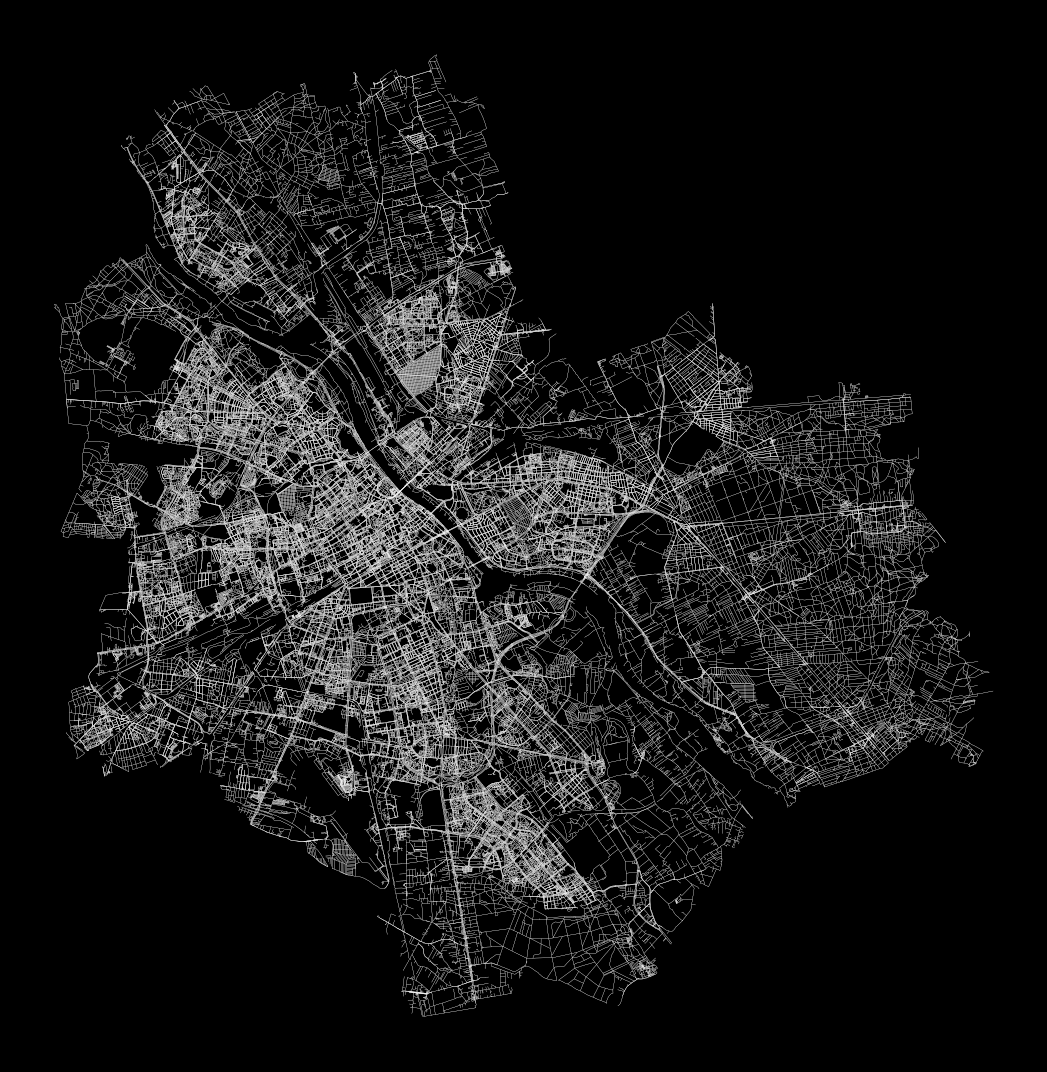

In [8]:
# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
#fig.set_facecolor((0.065,0.065,0.065))
#fig.set_facecolor((0.004,0.016,0.035))
fig.set_facecolor('black')

# Plot data
edges.plot(
    ax=ax,
    color=[1,1,1],
    linewidth=0.2
)

# Tight layout
plt.tight_layout()
plt.savefig('./docs/graph_overview.png')

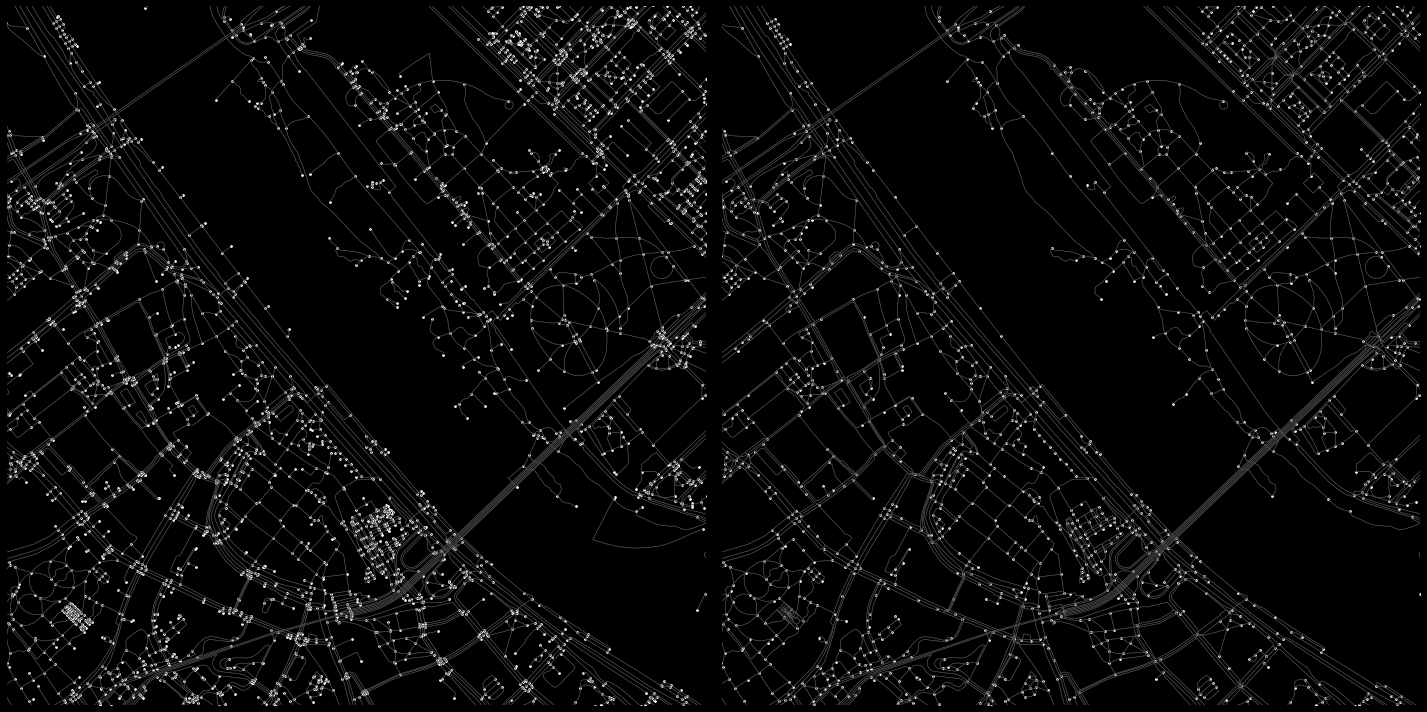

In [9]:
# Colors
facecol = 'black'
edgecol = [0.5,0.5,0.5]
nodecol = 'white'
linewidth = 0.5
markersize = 3

# Setup plot
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.set_facecolor(facecol)

# Plot data
edges.plot(
    ax=axs[0],
    color=edgecol,
    linewidth=linewidth
)
nodes.plot(
    ax=axs[0],
    color=nodecol,
    markersize=markersize
)

edges_s.plot(
    ax=axs[1],
    color=edgecol,
    linewidth=linewidth
)
nodes_s.plot(
    ax=axs[1],
    color=nodecol,
    markersize=markersize
)

# Zoom in
#plt.setp(axs[1][0], xlim=(4481000,4484000), ylim=(3621000,3624000))
#plt.setp(axs[1][1], xlim=(4481000,4484000), ylim=(3621000,3624000))
plt.setp(axs[0], xlim=(5069000,5071000), ylim=(3294000,3296000))
plt.setp(axs[1], xlim=(5069000,5071000), ylim=(3294000,3296000))

# Tight layout 
plt.tight_layout()
plt.savefig('./docs/graph_comparison.png')

In [10]:
# Print info
print(
    'number of nodes:\n\noriginal graph: '+str(len(nodes))
    +'\nsimplified graph: '+str(len(nodes_s))
)

number of nodes:

original graph: 177207
simplified graph: 96414


In [11]:
# Calculate points in polygon
intersection_count = gpd.sjoin(grid, nodes_s).groupby('grid_id').size().reset_index()
intersection_count = intersection_count.rename(columns={0: 'intersections'})
grid_intersections = grid.merge(intersection_count, on='grid_id')

In [12]:
# Statistics
print(grid_intersections['intersections'].describe())

count    3601.000000
mean       26.726187
std        29.914684
min         1.000000
25%         6.000000
50%        14.000000
75%        38.000000
max       199.000000
Name: intersections, dtype: float64


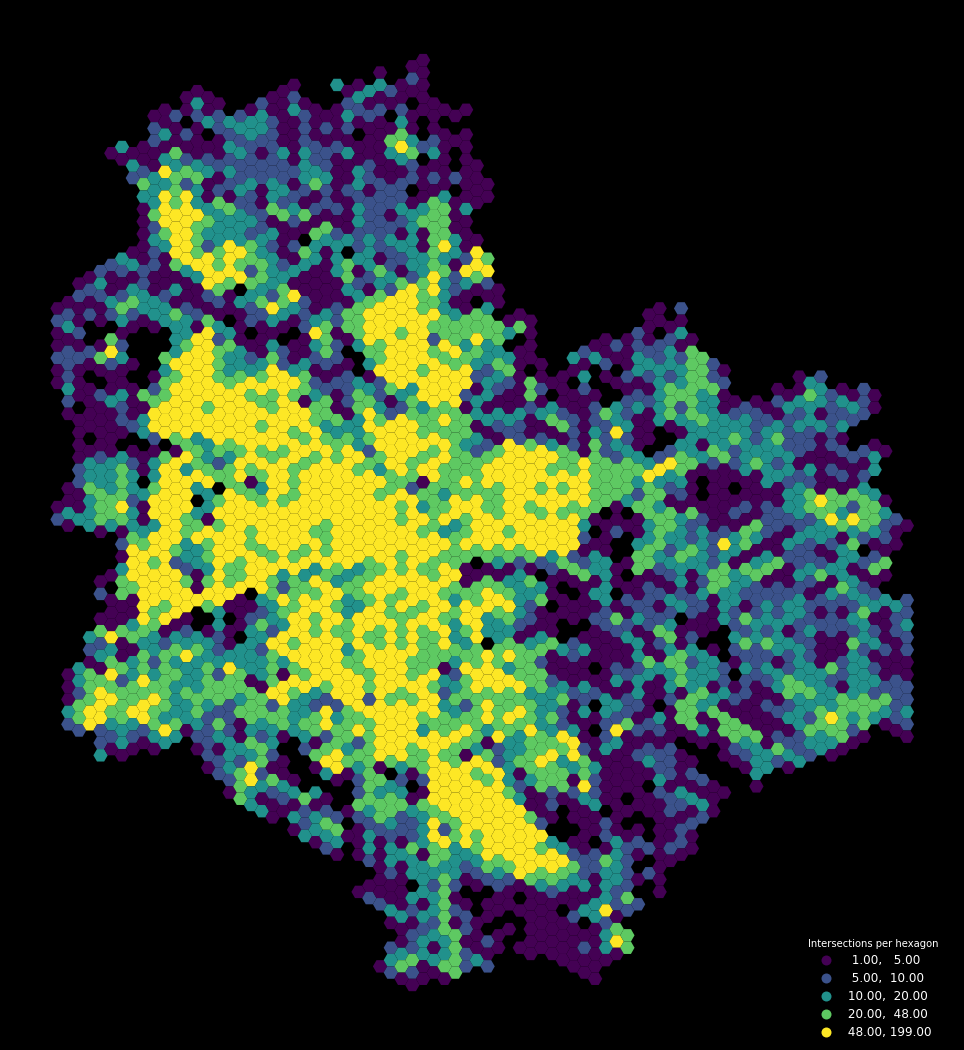

In [29]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
fig.set_facecolor('black')

grid_intersections.plot(
    ax=ax,
    column='intersections',
    scheme='quantiles',
    cmap='viridis',
    legend=True,
    edgecolor='none'
)



# Legend properties
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.99,0.105))
leg.set_title('Intersections per hexagon')

leg.get_label()

plt.setp(leg.get_texts(), color='w', fontsize=12)
leg.get_frame().set_edgecolor('none')
leg.get_frame().set_facecolor('none')


plt.tight_layout()
plt.savefig('./docs/intersection_grid.png')

In [14]:
# Save nodes
#nodes.to_file('./data/nodes.gpkg', driver='GPKG')
#nodes_s.to_file('./data/intersections.gpkg', driver='GPKG')

In [15]:
#grid_intersections.to_file('./data/grid_intersections.gpkg', driver='GPKG')

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
fig.set_facecolor('black')

nodes_s.plot(
    ax=ax,
    gridsize=75,
    kind='hexbin',
    x='x',
    y='y',
    cmap='viridis',
    #bins=5, 
    mincnt=1,
    vmax=200
)

plt.tight_layout()
plt.savefig('./docs/intersection_hexbin.png')